# 02__trans_motifs

in this notebook, i find motifs that are associated w/ trans effects using linear models and our RNA-seq data

In [1]:
import warnings
warnings.filterwarnings('ignore')

import itertools
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sys

from itertools import combinations 
from scipy.stats import boxcox
from scipy.stats import linregress
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from statsmodels.stats.anova import anova_lm

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

# import utils
sys.path.append("../../../utils")
from plotting_utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

In [3]:
np.random.seed(2019)

In [4]:
QUANT_ALPHA = 0.05

## functions

In [5]:
def calculate_gc(row, col):
    cs = row[col].count("C")
    gs = row[col].count("G")
    gc = (cs+gs)/len(row[col])
    return gc

In [6]:
def calculate_cpg(row, col):
    cpgs = row[col].count("CG")
    cpg = cpgs/len(row[col])
    return cpg

In [7]:
def sig_status(row):
    if row.padj_trans < 0.05:
        return "sig"
    else:
        return "not sig"

In [8]:
def neg_odds(row):
    if row["sig_status"] == "sig hESC":
        return -row["hESC_odds"]
    elif row["sig_status"] == "sig mESC":
        return row["mESC_odds"]
    else:
        return np.nan

In [9]:
def direction_match(row):
    if row.activ_or_repr == "activating":
        if row.beta_trans < 0 and row.logFC < 0:
            return "match"
        elif row.beta_trans > 0 and row.logFC > 0:
            return "match"
        else:
            return "no match"
    elif row.activ_or_repr == "repressing":
        if row.beta_trans < 0 and row.logFC > 0:
            return "match"
        elif row.beta_trans > 0 and row.logFC < 0:
            return "match"
        else:
            return "no match"
    else:
        return "unclear"

## variables

In [10]:
human_motifs_f = "../../../data/04__mapped_motifs/human_motifs_filtered.txt.gz"
mouse_motifs_f = "../../../data/04__mapped_motifs/mouse_motifs_filtered.txt.gz"

In [11]:
motif_info_dir = "../../../misc/01__motif_info"
motif_map_f = "%s/00__lambert_et_al_files/00__metadata/curated_motif_map.txt" % motif_info_dir
motif_info_f = "%s/00__lambert_et_al_files/00__metadata/motif_info.txt" % motif_info_dir

In [12]:
sig_motifs_f = "../../../data/04__mapped_motifs/sig_motifs.txt"

In [13]:
tss_map_f = "../../../data/01__design/01__mpra_list/mpra_tss.with_ids.RECLASSIFIED_WITH_MAX.txt"

In [14]:
index_f = "../../../data/01__design/02__index/TWIST_pool4_v8_final.with_element_id.txt.gz"

In [15]:
data_f = "../../../data/02__mpra/03__results/all_processed_results.txt"

In [16]:
expr_dir = "../../../data/03__rna_seq/04__TF_expr"
orth_expr_f = "%s/orth_TF_expression.txt" % expr_dir
human_expr_f = "%s/hESC_TF_expression.txt" % expr_dir
mouse_expr_f = "%s/mESC_TF_expression.txt" % expr_dir

In [17]:
orth_f = "../../../misc/00__ensembl_orthologs/ensembl96_human_mouse_orths.txt.gz"

## 1. import data

In [18]:
index = pd.read_table(index_f, sep="\t")
index_elem = index[["element", "tile_type", "element_id", "name", "tile_number", "chrom", "strand", "actual_start", 
                    "actual_end", "dupe_info"]]
index_elem = index_elem.drop_duplicates()

In [19]:
tss_map = pd.read_table(tss_map_f, sep="\t")
tss_map.head()

,hg19_id,mm9_id,cage_id_hg19,cage_id_mm9,name_peak_hg19,name_peak_mm9,biotype_hg19,biotype_mm9,minimal_biotype_hg19,minimal_biotype_mm9,...,stem_exp_mm9,max_cage_hg19,max_cage_mm9,orig_species,har,tss_tile_num_max_hg19,tss_tile_num_max_mm9,n_tiles_hg19,n_tiles_mm9,tile_match
0,h.0,m.0,"chr1:2984976..2984989,-","chr4:154011655..154011673,+",ENSG00000177133.6,ENSMUSG00000085069.2,divergent,divergent,lncRNA,lncRNA,...,0.0175,367.0,2286.0,human,False,NaN,NaN,NaN,NaN,NaN
1,h.1,m.0,"chr1:2984997..2985037,-","chr4:154011655..154011673,+",ENSG00000177133.6,ENSMUSG00000085069.2,divergent,divergent,lncRNA,lncRNA,...,0.0175,367.0,2286.0,human,False,NaN,NaN,NaN,NaN,NaN
2,h.2,m.1,"chr1:2985420..2985438,-","chr4:154011250..154011257,+",ENSG00000177133.6,ENSMUSG00000085069.2,divergent,divergent,lncRNA,lncRNA,...,0.0,6966.0,1361.0,human,False,tile1,tile1,2.0,2.0,tile1:tile1
3,h.3,m.2,"chr1:8086546..8086571,+","chr4:150229039..150229050,-",ENSG00000238290.1,ENSMUSG00000078492.3,divergent,antisense,lncRNA,lncRNA,...,0.0,960.0,123.0,human,False,tile1,tile1,1.0,1.0,tile1:tile1
4,h.4,m.3,"chr1:26498321..26498327,-","chr4:133799669..133799683,+",ENSG00000236782.1,ENSMUSG00000086322.7,antisense,protein_coding,other,mRNA,...,0.0,753.0,770.0,human,False,tile1,tile1,2.0,2.0,tile1:tile1


In [20]:
# this file is already filtered to correct tile nums
human_motifs = pd.read_table(human_motifs_f, sep="\t")
human_motifs.head()

,#pattern name,sequence name,start,stop,strand_x,score,p-value,q-value,matched sequence,elem_key,...,actual_end,dupe_info,tss_id,species,tss_tile_num,hg19_id,biotype_hg19,minimal_biotype_hg19,stem_exp_hg19,hg19_index
0,ZNF93,elem_12149,8,46,-,20.0704,7.460000e-08,0.000824,GGCGCTGAGAGCAGGAGCAGCAGCAGCTCCGGAGCAGAG,elem_12149,...,218519582,726.1.0.0,h.793,HUMAN,tile1,h.793,protein_coding,mRNA,0.0,h.793__tile1
1,ZNF571,elem_12149,105,119,+,17.8440,5.780000e-07,0.002630,CAGCCTCGGCGGCCC,elem_12149,...,218519582,726.1.0.0,h.793,HUMAN,tile1,h.793,protein_coding,mRNA,0.0,h.793__tile1
2,ZNF93,elem_12149,11,49,-,16.2746,1.190000e-06,0.004230,TGCGGCGCTGAGAGCAGGAGCAGCAGCAGCTCCGGAGCA,elem_12149,...,218519582,726.1.0.0,h.793,HUMAN,tile1,h.793,protein_coding,mRNA,0.0,h.793__tile1
3,ZNF93,elem_12149,5,43,-,15.2113,2.400000e-06,0.006280,GCTGAGAGCAGGAGCAGCAGCAGCTCCGGAGCAGAGAAG,elem_12149,...,218519582,726.1.0.0,h.793,HUMAN,tile1,h.793,protein_coding,mRNA,0.0,h.793__tile1
4,M10427_1,elem_12149,26,46,-,15.1735,2.720000e-06,0.003270,GGCGCTGAGAGCAGGAGCAGC,elem_12149,...,218519582,726.1.0.0,h.793,HUMAN,tile1,h.793,protein_coding,mRNA,0.0,h.793__tile1


In [21]:
# this file is already filtered to correct tile nums
mouse_motifs = pd.read_table(mouse_motifs_f, sep="\t")
mouse_motifs.head()

,#pattern name,sequence name,start,stop,strand_x,score,p-value,q-value,matched sequence,elem_key,...,actual_end,dupe_info,tss_id,species,tss_tile_num,mm9_id,biotype_mm9,minimal_biotype_mm9,stem_exp_mm9,mm9_index
0,ZNF785,elem_9927,4,32,-,31.7041,3.800000e-11,2.690000e-07,AGTCGCACACACACACACACACACACACA,elem_9927,...,120217220,9280.1.0.0,m.3178,MOUSE,tile1,m.3178,protein_coding,mRNA,0.045,m.3178__tile1
1,ZNF785,elem_9927,2,30,-,19.9490,1.510000e-08,6.260000e-05,TCGCACACACACACACACACACACACATA,elem_9927,...,120217220,9280.1.0.0,m.3178,MOUSE,tile1,m.3178,protein_coding,mRNA,0.045,m.3178__tile1
2,ZNF785,elem_9927,49,77,-,16.8265,5.010000e-08,1.890000e-04,ATACGCGCGCACACACATACATACACACA,elem_9927,...,120217220,9280.1.0.0,m.3178,MOUSE,tile1,m.3178,protein_coding,mRNA,0.045,m.3178__tile1
3,ZNF785,elem_9927,47,75,-,13.4796,1.610000e-07,5.620000e-04,ACGCGCGCACACACATACATACACACATA,elem_9927,...,120217220,9280.1.0.0,m.3178,MOUSE,tile1,m.3178,protein_coding,mRNA,0.045,m.3178__tile1
4,ZNF785,elem_9927,41,69,-,12.0816,2.540000e-07,8.380000e-04,GCACACACATACATACACACATACACACA,elem_9927,...,120217220,9280.1.0.0,m.3178,MOUSE,tile1,m.3178,protein_coding,mRNA,0.045,m.3178__tile1


In [22]:
motif_info = pd.read_table(motif_info_f, sep="\t")
motif_info.head()

,Ensembl ID,HGNC symbol,Motif evidence,Motif ID,Motif type,Motif source,CIS-BP ID,Best Motif(s)? (Figure 2A)
0,ENSG00000267281,AC023509.3,"Inferred - ATF7 (100% AA Identity, Homo sapiens)",ATF7_eDBD_HT-SELEX,HT-SELEX,Yin2017,M08490_1.94d,True
1,ENSG00000267281,AC023509.3,"Inferred - ATF7 (100% AA Identity, Homo sapiens)",ATF7_eDBD_Methyl-HT-SELEX,Methyl-HT-SELEX,Yin2017,M08491_1.94d,NaN
2,ENSG00000267281,AC023509.3,"Inferred - Atf7 (98% AA Identity, Mus musculus)",3T3L1-Atf7_GSE56872,Misc,HOMER,M06975_1.94d,NaN
3,ENSG00000264668,AC138696.1,"Inferred - ZFP41 (100% AA Identity, Homo sapiens)",ZFP41_FL_HT-SELEX,HT-SELEX,Yin2017,M09315_1.94d,True
4,ENSG00000264668,AC138696.1,"Inferred - ZFP41 (100% AA Identity, Homo sapiens)",ZFP41_FL_Methyl-HT-SELEX,Methyl-HT-SELEX,Yin2017,M09316_1.94d,NaN


In [23]:
sig_motifs = pd.read_table(sig_motifs_f)
sig_motifs = sig_motifs[sig_motifs["padj"] < 0.05]
print(len(sig_motifs))
sig_motifs.head()

466


,index,lr_test,pval,rsq,beta,padj,short_id,HGNC symbol,activ_or_repr,no_CAGE_enr,eRNA_enr,lncRNA_enr,mRNA_enr
0,M05563_1,10.635973,0.001109,0.000650,-0.216131,0.004402,M05563_1,AR,repressing,NaN,NaN,NaN,NaN
1,M05564_1,16.352510,0.000053,0.001000,-0.239688,0.000291,M05564_1,AR,repressing,NaN,1.0,NaN,NaN
2,M00144_1,10.738762,0.001049,0.000657,-0.275327,0.004203,M00144_1,ARID5A,repressing,0.0,NaN,NaN,NaN
3,M00226_1,6.933266,0.008461,0.000424,0.133341,0.027122,M00226_1,ARNT,activating,NaN,NaN,NaN,NaN
4,M08469_1,17.121412,0.000035,0.001047,0.200435,0.000201,M08469_1,ARNT2,activating,NaN,NaN,NaN,NaN


In [24]:
data = pd.read_table(data_f)
data.head()

,hg19_id,chr_tss_hg19,start_tss_hg19,biotype_hg19,cage_id_hg19,name_peak_hg19,minimal_biotype_hg19,stem_exp_hg19,mm9_id,chr_tss_mm9,...,trans_mouse_status,trans_human_status_det,trans_mouse_status_det,trans_status_one,trans_status_det_one,logFC_trans_one,logFC_int,fdr_int,cis_trans_int_status,cis_trans_int_status_det
0,h.2,chr1,2985430.0,divergent,"chr1:2985420..2985438,-",ENSG00000177133.6,lncRNA,0.07111110000000001,m.1,chr4,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,-0.325920,-0.050780,0.991115,no cis/trans int. effect,no cis/trans int. effect
1,h.3,chr1,8086552.0,divergent,"chr1:8086546..8086571,+",ENSG00000238290.1,lncRNA,0.10444400000000001,m.2,chr4,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,0.533476,-0.405629,0.908445,no cis/trans int. effect,no cis/trans int. effect
2,h.4,chr1,26498322.0,antisense,"chr1:26498321..26498327,-",ENSG00000236782.1,other,0.03,m.3,chr4,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,0.270223,-0.210732,0.960813,no cis/trans int. effect,no cis/trans int. effect
3,h.5,chr1,65533428.0,intergenic,"chr1:65533390..65533443,-",ENSG00000231485.1,lncRNA,0.841111,m.4,chr4,...,no trans effect,trans effect\n(higher in mouse),no trans effect,significant trans effect,trans effect\n(higher in mouse),0.449668,-0.740913,0.152051,no cis/trans int. effect,no cis/trans int. effect
4,h.6,chr1,65533462.0,intergenic,"chr1:65533457..65533465,-",ENSG00000231485.1,lncRNA,0.116667,m.4,chr4,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,-0.270646,-0.528464,0.379849,no cis/trans int. effect,no cis/trans int. effect


In [25]:
orth_expr = pd.read_table(orth_expr_f, sep="\t")
orth_expr.head()

,gene_id_human,gene_name_human,mean_tpm_human,gene_id_mouse,gene_name_mouse,mean_tpm_mouse,AveExpr,logFC,adj.P.Val,sig,neg_log_padj
0,ENSG00000142611,PRDM16,55.601719,ENSMUSG00000039410,Prdm16,612.953260,2.510447,4.964306,1.771139e-10,sig,9.751747
1,ENSG00000078900,TP73,117.897387,ENSMUSG00000029026,Trp73,239.674040,2.530112,2.552952,4.216300e-07,sig,6.375069
2,ENSG00000173673,HES3,272.208698,ENSMUSG00000028946,Hes3,0.000000,-1.119951,-7.611337,1.590728e-10,sig,9.798404
3,ENSG00000204859,ZBTB48,1251.437325,ENSMUSG00000028952,Zbtb48,342.804146,4.430457,-0.387987,5.686419e-02,not sig,1.245161
4,ENSG00000125945,ZNF436,136.434616,ENSMUSG00000051351,Zfp46,177.665949,2.222969,1.836888,4.656334e-06,sig,5.331956


In [26]:
human_expr = pd.read_table(human_expr_f, sep="\t")
human_expr.head()

,index,gene_name,mean_tpm
0,ENSG00000188290,HES4,10.378615
1,ENSG00000197921,HES5,2.664051
2,ENSG00000142611,PRDM16,55.601719
3,ENSG00000078900,TP73,117.897387
4,ENSG00000173673,HES3,272.208698


In [27]:
mouse_expr = pd.read_table(mouse_expr_f, sep="\t")
mouse_expr.head()

,gene_id_human,gene_name_human,gene_id_mouse,gene_name_mouse,mean_tpm_mouse
0,ENSG00000197921,HES5,ENSMUSG00000048001,Hes5,0.000000
1,ENSG00000142611,PRDM16,ENSMUSG00000039410,Prdm16,612.953260
2,ENSG00000078900,TP73,ENSMUSG00000029026,Trp73,239.674040
3,ENSG00000173673,HES3,ENSMUSG00000028946,Hes3,0.000000
4,ENSG00000069812,HES2,ENSMUSG00000028940,Hes2,1.949365


In [28]:
orth = pd.read_table(orth_f, sep="\t")
orth.head()

,Gene stable ID,Transcript stable ID,Gene name,Mouse gene stable ID,Mouse protein or transcript stable ID,Mouse gene name,%id. target Mouse gene identical to query gene,%id. query gene identical to target Mouse gene,dN with Mouse,dS with Mouse,"Mouse orthology confidence [0 low, 1 high]",Mouse homology type
0,ENSG00000198888,ENST00000361390,MT-ND1,ENSMUSG00000064341,ENSMUSP00000080991,mt-Nd1,77.0440,77.0440,NaN,NaN,1.0,ortholog_one2one
1,ENSG00000198763,ENST00000361453,MT-ND2,ENSMUSG00000064345,ENSMUSP00000080992,mt-Nd2,57.0605,57.3913,NaN,NaN,1.0,ortholog_one2one
2,ENSG00000198804,ENST00000361624,MT-CO1,ENSMUSG00000064351,ENSMUSP00000080993,mt-Co1,90.8382,90.6615,NaN,NaN,1.0,ortholog_one2one
3,ENSG00000198712,ENST00000361739,MT-CO2,ENSMUSG00000064354,ENSMUSP00000080994,mt-Co2,71.3656,71.3656,NaN,NaN,1.0,ortholog_one2one
4,ENSG00000228253,ENST00000361851,MT-ATP8,ENSMUSG00000064356,ENSMUSP00000080995,mt-Atp8,45.5882,46.2687,0.49,0.85,0.0,ortholog_one2one


## 2. merge data to build model

In [29]:
index_elem = index_elem[index_elem["name"].str.contains("EVO")]
index_elem.head()

,element,tile_type,element_id,name,tile_number,chrom,strand,actual_start,actual_end,dupe_info
58627,CTTCGTGCCTGGACACCGTCCCCCAGCCTGGCTCCAGCTGCCCCGG...,WILDTYPE,"HUMAN_EVO_TSS__h.1539__tile2:1355317-1355461,+...",HUMAN_EVO_TSS__h.1539__tile2,1.0,chr1,+,1355317,1355461,11.1.0.0
58640,CTGGGAGCGGCCTAGGGCGGCCGCCAGACCCAGCGCTGTGGCCCCC...,WILDTYPE,"HUMAN_EVO_TSS__h.1539__tile1:1355431-1355575,+...",HUMAN_EVO_TSS__h.1539__tile1,1.0,chr1,+,1355431,1355575,12.1.0.0
58653,GGGCTGACGCTGCCTTGGGTTCGCCTACGTCCCTCGGGAATTTTGT...,WILDTYPE,"HUMAN_EVO_TSS__h.3020__tile2:1447313-1447457,+...",HUMAN_EVO_TSS__h.3020__tile2,1.0,chr1,+,1447313,1447457,13.1.0.0
58666,CCACACACACCCCTTCCTCCCGGCGATAGAAGCGCGTAAGGGACAC...,WILDTYPE,"HUMAN_EVO_TSS__h.2871__tile1:1447388-1447532,-...",HUMAN_EVO_TSS__h.2871__tile1,1.0,chr1,-,1447388,1447532,14.1.0.0
58679,AGTCGCGGCGCCGTCGCTATGGCGTCACTGTCCTCGGGGCCAATCC...,WILDTYPE,"HUMAN_EVO_TSS__h.3020__tile1:1447427-1447571,+...",HUMAN_EVO_TSS__h.3020__tile1,1.0,chr1,+,1447427,1447571,15.1.0.0


In [30]:
index_elem["tss_id"] = index_elem["name"].str.split("__", expand=True)[1]
index_elem["tss_tile_num"] = index_elem["name"].str.split("__", expand=True)[2]
index_elem.sample(5)

,element,tile_type,element_id,name,tile_number,chrom,strand,actual_start,actual_end,dupe_info,tss_id,tss_tile_num
233776,AGTTTGCAAATCTAGCAGCTGGAGTGTGTTTGTGGTAGCTGCTTTC...,WILDTYPE,MOUSE_EVO_TSS__m.2089__tile1:111587703-1115878...,MOUSE_EVO_TSS__m.2089__tile1,1.0,chrX,+,111587703,111587847,14280.1.0.0,m.2089,tile1
112967,GGAGGGCGAGACGCGGCTTTCCCTTCGGCGCCCGGGTGCGTGCGTG...,WILDTYPE,HUMAN_EVO_TSS__h.2771__tile1:30946063-30946207...,HUMAN_EVO_TSS__h.2771__tile1,1.0,chr20,-,30946063,30946207,4430.1.0.0,h.2771,tile1
153384,TCCTCCTGCCTATCTCCAGTCTGGGATTATAGGCAGAAACCATCAA...,WILDTYPE,MOUSE_EVO_TSS__m.3217__tile1:166390028-1663901...,MOUSE_EVO_TSS__m.3217__tile1,1.0,chr1,-,166390028,166390172,7681.1.0.0,m.3217,tile1
203746,AGGCTGGAAAGACGAAAGGCGGGCGGGTGTTTTCAGAGCAGGAGCC...,WILDTYPE,MOUSE_EVO_TSS__m.1141__tile2:57166518-57166662...,MOUSE_EVO_TSS__m.1141__tile2,1.0,chr4,-,57166518,57166662,11794.1.0.0,m.1141,tile2
195296,TAGGGGCAGGAAGCAGAGCCAGCCAGGGTGGGGTCAGAGAGATAAG...,WILDTYPE,MOUSE_EVO_TSS__m.3273__tile2:152567328-1525674...,MOUSE_EVO_TSS__m.3273__tile2,1.0,chr2,-,152567328,152567472,11114.1.0.0,m.3273,tile2


In [31]:
index_human = index_elem[index_elem["name"].str.contains("HUMAN")]
index_mouse = index_elem[index_elem["name"].str.contains("MOUSE")]
index_mouse.sample(5)

,element,tile_type,element_id,name,tile_number,chrom,strand,actual_start,actual_end,dupe_info,tss_id,tss_tile_num
207867,GCTTAGGTGGCTTGGGACTTGGCTGGGTGTCAGGAAAATGTTGAAC...,WILDTYPE,MOUSE_EVO_TSS__m.1891__tile1:22795995-22796139...,MOUSE_EVO_TSS__m.1891__tile1,1.0,chr5,-,22795995,22796139,12140.1.0.0,m.1891,tile1
174561,GAGAGGTCGGGCTTGGAGGACACGTCCATCTCCACGGAGATCTGAG...,WILDTYPE,MOUSE_EVO_TSS__m.1777__tile2:68702642-68702786...,MOUSE_EVO_TSS__m.1777__tile2,1.0,chr14,-,68702642,68702786,9408.1.0.0,m.1777,tile2
211637,GAAAGTAAGGGAAGACACCAAACTCTCTCGAGCCACAAGCAAACTG...,WILDTYPE,MOUSE_EVO_TSS__m.2652__tile2:134652008-1346521...,MOUSE_EVO_TSS__m.2652__tile2,1.0,chr5,+,134652008,134652152,12457.1.0.0,m.2652,tile2
207113,ACGAGCAAGGAATGTTTTCTTAAAGGGCCAGTTCCGAGCTGCGCTG...,WILDTYPE,MOUSE_EVO_TSS__m.761__tile1:154011047-15401119...,MOUSE_EVO_TSS__m.761__tile1,1.0,chr4,-,154011047,154011191,12080.1.0.0,m.761,tile1
177330,AGTAATGAATAAGAAGTGAAGTCACTGATGGCAGCAATGGGTAAGG...,WILDTYPE,MOUSE_EVO_TSS__m.2354__tile1:79332381-79332525...,MOUSE_EVO_TSS__m.2354__tile1,1.0,chr15,+,79332381,79332525,9645.1.0.0,m.2354,tile1


In [32]:
print(len(data))
data_elem = data.merge(index_human[["element", "tss_id", "tss_tile_num"]], left_on=["hg19_id", "tss_tile_num"],
                       right_on=["tss_id", "tss_tile_num"])
data_elem = data_elem.merge(index_mouse[["element", "tss_id", "tss_tile_num"]], left_on=["mm9_id", "tss_tile_num"],
                            right_on=["tss_id", "tss_tile_num"], suffixes=("_human", "_mouse"))
data_elem.drop(["tss_id_human", "tss_id_mouse"], axis=1, inplace=True)
print(len(data))
data_elem.head()

2952
2952


,hg19_id,chr_tss_hg19,start_tss_hg19,biotype_hg19,cage_id_hg19,name_peak_hg19,minimal_biotype_hg19,stem_exp_hg19,mm9_id,chr_tss_mm9,...,trans_mouse_status_det,trans_status_one,trans_status_det_one,logFC_trans_one,logFC_int,fdr_int,cis_trans_int_status,cis_trans_int_status_det,element_human,element_mouse
0,h.2,chr1,2985430.0,divergent,"chr1:2985420..2985438,-",ENSG00000177133.6,lncRNA,0.07111110000000001,m.1,chr4,...,no trans effect,no trans effect,no trans effect,-0.325920,-0.050780,0.991115,no cis/trans int. effect,no cis/trans int. effect,CCTTTTCAGCGCAGCTCGGAACTGGCCCTTTAAGAAAACATTCCGT...,CCCTTTTCAGCGCAGCTCGGAACTGGCCCTTTAAGAAAACATTCCT...
1,h.3,chr1,8086552.0,divergent,"chr1:8086546..8086571,+",ENSG00000238290.1,lncRNA,0.10444400000000001,m.2,chr4,...,no trans effect,no trans effect,no trans effect,0.533476,-0.405629,0.908445,no cis/trans int. effect,no cis/trans int. effect,CCGCCTCCTCCCGCAGCCAATCAGGGCGCGCGCCGCTTAAAGGGGC...,TATTTATACGGTGAGCGACAACGTGACGTCAACGCCCGCAGCCCCG...
2,h.4,chr1,26498322.0,antisense,"chr1:26498321..26498327,-",ENSG00000236782.1,other,0.03,m.3,chr4,...,no trans effect,no trans effect,no trans effect,0.270223,-0.210732,0.960813,no cis/trans int. effect,no cis/trans int. effect,TGCCGCTCAAGCCTGATGCTGATCTCTTTTGACAGCTGCTTCTAAG...,GATATTCAGGCCTGATGCTGATCCCTCCTGACAGCTGCTCCTAAGG...
3,h.5,chr1,65533428.0,intergenic,"chr1:65533390..65533443,-",ENSG00000231485.1,lncRNA,0.841111,m.4,chr4,...,no trans effect,significant trans effect,trans effect\n(higher in mouse),0.449668,-0.740913,0.152051,no cis/trans int. effect,no cis/trans int. effect,AGAGTTGTGTCTCGTCTCCCTTTTGTTTTTCTCCCTTCCCGGTCAT...,TGAGACCCGGAAGTTTTTTTTTTTTTTTTTTTTCCTTCAATCCTGT...
4,h.6,chr1,65533462.0,intergenic,"chr1:65533457..65533465,-",ENSG00000231485.1,lncRNA,0.116667,m.4,chr4,...,no trans effect,no trans effect,no trans effect,-0.270646,-0.528464,0.379849,no cis/trans int. effect,no cis/trans int. effect,CATACACACACGCACGCACACACATCCTTCCCTTAGAGTTGTGTCT...,TGAGACCCGGAAGTTTTTTTTTTTTTTTTTTTTCCTTCAATCCTGT...


In [33]:
data_elem["gc_human"] = data_elem.apply(calculate_gc, col="element_human", axis=1)
data_elem["gc_mouse"] = data_elem.apply(calculate_gc, col="element_mouse", axis=1)
data_elem["cpg_human"] = data_elem.apply(calculate_cpg, col="element_human", axis=1)
data_elem["cpg_mouse"] = data_elem.apply(calculate_cpg, col="element_mouse", axis=1)
data_elem.sample(5)

,hg19_id,chr_tss_hg19,start_tss_hg19,biotype_hg19,cage_id_hg19,name_peak_hg19,minimal_biotype_hg19,stem_exp_hg19,mm9_id,chr_tss_mm9,...,logFC_int,fdr_int,cis_trans_int_status,cis_trans_int_status_det,element_human,element_mouse,gc_human,gc_mouse,cpg_human,cpg_mouse
546,h.905,chr1,229644073.0,protein_coding,"chr1:229644034..229644123,-",ENSG00000069248.9,mRNA,69.7822,m.789,chr8,...,-0.129017,0.931772,no cis/trans int. effect,no cis/trans int. effect,TGACTGGGCACCGCCCTTAACGTCACGATCCCGCCCCCGCCAGCGC...,GTGACGTCAACAAAGCGCTCCCAGTTCCGACCTTGCCCCGAGTCTC...,0.638889,0.631944,0.118056,0.097222
2002,h.3099,chr19,34850492.0,no cage activity,no cage activity,no cage activity,lncRNA,no cage activity,m.2910,chr7,...,0.035750,0.991115,no cis/trans int. effect,no cis/trans int. effect,CGCCCCATCCGCGCCTGCGCTCAACCCCGCCTACACCTGCTCCGTG...,CGCGTGCTCGCCGCTTCCATGCGCGTGGTCTCGCCCCGCCCCCGCA...,0.708333,0.708333,0.104167,0.118056
1594,h.2548,chr3,128446613.0,enhancer,chr3:128446542-128446927,chr3:128446542-128446927__POSITIVE,eRNA,0.084828,m.2360,chr6,...,-0.507378,0.224416,no cis/trans int. effect,no cis/trans int. effect,AACCTTAGTTGATGGCTGTCCAGCCGGCTGGTTCTTCCCTATTCAA...,CAAGAATTTCTACAACAACCTAACCTGTTGACTCTTCACCGTTGAA...,0.423611,0.347222,0.013889,0.006944
2523,h.1105,chr8,92082571.0,protein_coding,"chr8:92082535..92082597,+",ENSG00000155100.6,mRNA,24.93,m.987,chr4,...,0.115591,0.985989,no cis/trans int. effect,no cis/trans int. effect,GAGGCTGCAAACTCCGCTTCTCCGCTCGCAGTCTGGTTCCTCCCCT...,TGCGGTTGCTCCAGCGCCGGGCGCGTCCTTAATCGCACAATCCCAG...,0.631944,0.701389,0.090278,0.138889
2150,h.3326,chr18,11908691.0,no cage activity,no cage activity,no cage activity,mRNA,no cage activity,m.3136,chr18,...,0.109117,0.991115,no cis/trans int. effect,no cis/trans int. effect,GCGCCCCGCAACGGGCCTTTCCTGGGCCCTAACGACAGCTCGCCCG...,CAGGTCCCGCGGTCCCCAGGCGCGCGGTTCGGTCCCCAACGAGCCG...,0.673611,0.715278,0.097222,0.118056


In [34]:
data_elem.columns

Index(['hg19_id', 'chr_tss_hg19', 'start_tss_hg19', 'biotype_hg19',
       'cage_id_hg19', 'name_peak_hg19', 'minimal_biotype_hg19',
       'stem_exp_hg19', 'mm9_id', 'chr_tss_mm9', 'start_tss_mm9',
       'biotype_mm9', 'cage_id_mm9', 'name_peak_mm9', 'minimal_biotype_mm9',
       'stem_exp_mm9', 'tss_tile_num', 'orig_species',
       'biotype_switch_minimal', 'HUES64_hg19', 'mESC_hg19', 'HUES64_mm9',
       'mESC_mm9', 'HUES64_padj_hg19', 'mESC_padj_hg19', 'HUES64_padj_mm9',
       'mESC_padj_mm9', 'logFC_native', 'fdr_native', 'native_status',
       'native_status_det', 'logFC_cis_HUES64', 'fdr_cis_HUES64',
       'logFC_cis_mESC', 'fdr_cis_mESC', 'cis_HUES64_status',
       'cis_mESC_status', 'cis_HUES64_status_det', 'cis_mESC_status_det',
       'cis_status_one', 'cis_status_det_one', 'logFC_cis_one',
       'logFC_trans_human', 'fdr_trans_human', 'logFC_trans_mouse',
       'fdr_trans_mouse', 'trans_human_status', 'trans_mouse_status',
       'trans_human_status_det', 'trans_mou

In [35]:
data_human = data_elem[["hg19_id", "tss_tile_num", "logFC_trans_human", "gc_human", "cpg_human", "HUES64_padj_hg19", "trans_status_one"]]
data_mouse = data_elem[["mm9_id", "tss_tile_num", "logFC_trans_mouse", "gc_mouse", "cpg_mouse", "mESC_padj_mm9", "trans_status_one"]]
data_human.columns = ["tss_id", "tss_tile_num", "logFC_trans", "gc", "cpg", "padj", "trans_status"]
data_mouse.columns = ["tss_id", "tss_tile_num", "logFC_trans", "gc", "cpg", "padj", "trans_status"]
data_indiv = data_human.append(data_mouse).drop_duplicates()
print(len(data_indiv))
data_indiv.head()

5868


,tss_id,tss_tile_num,logFC_trans,gc,cpg,padj,trans_status
0,h.2,tile1,-0.323505,0.652778,0.083333,1.812116e-03,no trans effect
1,h.3,tile1,0.476062,0.743056,0.145833,4.883017e-01,no trans effect
2,h.4,tile1,0.270223,0.604167,0.027778,2.428031e-01,no trans effect
3,h.5,tile1,0.449668,0.430556,0.034722,1.368040e-14,significant trans effect
4,h.6,tile1,0.243406,0.465278,0.041667,3.003835e-10,no trans effect


## 3. build reduced model

In [36]:
scaled_features = StandardScaler().fit_transform(data_indiv[["logFC_trans", "gc", "cpg"]])
data_norm = pd.DataFrame(scaled_features, index=data_indiv.index, columns=["logFC_trans", "gc", "cpg"])
data_norm["padj"] = data_indiv["padj"]
data_norm["tss_id"] = data_indiv["tss_id"]
data_norm["tss_tile_num"] = data_indiv["tss_tile_num"]
data_norm["trans_status"] = data_indiv["trans_status"]
data_norm.head()

,logFC_trans,gc,cpg,padj,tss_id,tss_tile_num,trans_status
0,-1.317363,0.725390,0.789796,1.812116e-03,h.2,tile1,no trans effect
1,0.964619,1.597586,2.351235,4.883017e-01,h.3,tile1,no trans effect
2,0.377150,0.255745,-0.598149,2.428031e-01,h.4,tile1,no trans effect
3,0.889292,-1.421555,-0.424656,1.368040e-14,h.5,tile1,significant trans effect
4,0.300615,-1.086095,-0.251163,3.003835e-10,h.6,tile1,no trans effect


In [37]:
data_filt = data_norm[data_norm["padj"] < QUANT_ALPHA].drop_duplicates()
print(len(data_filt))
data_filt.head()

2427


,logFC_trans,gc,cpg,padj,tss_id,tss_tile_num,trans_status
0,-1.317363,0.725390,0.789796,1.812116e-03,h.2,tile1,no trans effect
3,0.889292,-1.421555,-0.424656,1.368040e-14,h.5,tile1,significant trans effect
4,0.300615,-1.086095,-0.251163,3.003835e-10,h.6,tile1,no trans effect
5,0.244979,-0.012623,-0.424656,7.028182e-155,h.7,tile1,no trans effect
9,-1.278287,0.926666,0.789796,0.000000e+00,h.11,tile1,no trans effect


In [38]:
mod = smf.ols(formula='logFC_trans ~ gc + cpg', 
              data=data_filt).fit()

In [39]:
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            logFC_trans   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     30.65
Date:                Tue, 31 Mar 2020   Prob (F-statistic):           7.12e-14
Time:                        21:21:16   Log-Likelihood:                -3730.1
No. Observations:                2427   AIC:                             7466.
Df Residuals:                    2424   BIC:                             7484.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3194      0.027    -11.864      0.000      -0.372      -0.267
gc            -0.0688      0.045     -1.527      0.127      -0.157       0.020
cpg            0.2312      0.035      6.513      0.000       0.162       0.301
==============================================================================
Omnibus:                       83.379   Durbin-Watson:                   1.797
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              123.234
Skew:                          -0.332   Prob(JB):                     1.74e-27
Kurtosis:                       3.881   Cond. No.                         3.30
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.5, 1.0, 'Normal QQ: trans effects model')

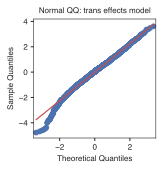

In [40]:
res = mod.resid

fig, ax = plt.subplots(figsize=(2.2, 2.2), ncols=1, nrows=1)
sm.qqplot(res, line='s', ax=ax)
ax.set_title("Normal QQ: trans effects model")
# fig.savefig("avg_activ_qq.pdf", dpi="figure", bbox_inches="tight")

In [41]:
reduced_llf = mod.llf
reduced_llf

-3730.112080211595

In [42]:
reduced_rsq = mod.rsquared
reduced_rsq

0.024668592642085208

## 4. add motifs to model

In [43]:
data_filt["tss_index"] = data_filt["tss_id"] + "__" + data_filt["tss_tile_num"]

In [44]:
human_motifs["hg19_index"] = human_motifs["hg19_id"] + "__" + human_motifs["tss_tile_num"]
mouse_motifs["mm9_index"] = mouse_motifs["mm9_id"] + "__" + mouse_motifs["tss_tile_num"]

In [45]:
uniq_motifs = list(set(list(human_motifs["#pattern name"].unique()) + list(mouse_motifs["#pattern name"].unique())))
len(uniq_motifs)

448

In [46]:
def tss_motif(row):
    if row.human_motif:
        return True
    elif row.mouse_motif:
        return True
    else:
        return False

In [47]:
motif_results = {}

for i, motif_id in enumerate(uniq_motifs):
    tmp = data_filt.copy()
    
    # determine whether motif is in human or mouse sequence
    human_motifs_sub = human_motifs[human_motifs["#pattern name"] == motif_id]["hg19_index"].unique()
    mouse_motifs_sub = mouse_motifs[mouse_motifs["#pattern name"] == motif_id]["mm9_index"].unique()
    tmp["human_motif"] = tmp["tss_index"].isin(human_motifs_sub)
    tmp["mouse_motif"] = tmp["tss_index"].isin(mouse_motifs_sub)
    tmp["tss_motif"] = tmp.apply(tss_motif, axis=1)
    n_w_motif = tmp["tss_motif"].sum()
    
    # make full model
    full_mod = smf.ols(formula='logFC_trans ~ gc + cpg + tss_motif', 
                       data=tmp).fit()
    full_llf = full_mod.llf
    full_rsq = full_mod.rsquared
    
#     # perform likelihood ratio test
#     lr, p = lrtest(reduced_llf, full_llf)
    
    # calculate additional variance explained
    rsq = full_rsq - reduced_rsq
    
    # record beta
    beta = list(full_mod.params)[1]
    
    # beta p
    beta_p = list(full_mod.pvalues)[1]
    
    print("(#%s) %s: n w/ motif: %s ... p: %s, rsquared: %s" % (i+1, motif_id, len(tmp), beta_p, rsq))
    motif_results[motif_id] = {"rsq": rsq, "beta": beta, "beta_p": beta_p, "n_w_motif": n_w_motif}

(#1) M00880_1: n w/ motif: 2427 ... p: 0.5893202898826874, rsquared: 0.00011731736356868083
(#2) M05695_1: n w/ motif: 2427 ... p: 4.1947191770093725e-08, rsquared: 0.012026699172396182
(#3) M08469_1: n w/ motif: 2427 ... p: 6.439213751490177e-07, rsquared: 0.009924341080470911
(#4) M09267_1: n w/ motif: 2427 ... p: 0.00013366295114328197, rsquared: 0.00585624533521778
(#5) M06860_1: n w/ motif: 2427 ... p: 0.6430341473674297, rsquared: 8.64758954211009e-05
(#6) M10260_1: n w/ motif: 2427 ... p: 7.085193802618909e-07, rsquared: 0.0098509129851867
(#7) M08476_1: n w/ motif: 2427 ... p: 0.43463529446669513, rsquared: 0.0002457264503605838
(#8) M05674_1: n w/ motif: 2427 ... p: 4.31967748277693e-08, rsquared: 0.012004063816301036
(#9) M09436_1: n w/ motif: 2427 ... p: 0.22075804578755637, rsquared: 0.0006035067957730345
(#10) M05963_1: n w/ motif: 2427 ... p: 0.03991485432871924, rsquared: 0.0016981532083413242
(#11) M09446_1: n w/ motif: 2427 ... p: 0.19405497552590992, rsquared: 0.00067

(#90) M08912_1: n w/ motif: 2427 ... p: 0.18145638780373055, rsquared: 0.0007186642569252388
(#91) ZNF211: n w/ motif: 2427 ... p: 0.2858675041800533, rsquared: 0.0004584618921493755
(#92) M10446_1: n w/ motif: 2427 ... p: 0.06323448088176464, rsquared: 0.0013882098471462712
(#93) M05699_1: n w/ motif: 2427 ... p: 1.129545792194452e-08, rsquared: 0.013039056564393636
(#94) M08872_1: n w/ motif: 2427 ... p: 1.6915704066951333e-05, rsquared: 0.00742333850413579
(#95) M09509_1: n w/ motif: 2427 ... p: 7.839637325689407e-14, rsquared: 0.022226962071213108
(#96) M06019_1: n w/ motif: 2427 ... p: 0.00015171730914817486, rsquared: 0.005760735846032983
(#97) M06794_1: n w/ motif: 2427 ... p: 0.03212395851895018, rsquared: 0.0018469978544068955
(#98) M06138_1: n w/ motif: 2427 ... p: 0.001795096648942843, rsquared: 0.0039168250070279464
(#99) ZNF684: n w/ motif: 2427 ... p: 0.4575738940705175, rsquared: 0.00022214600785830374
(#100) M00224_1: n w/ motif: 2427 ... p: 0.37113167957993864, rsquare

(#178) M07567_1: n w/ motif: 2427 ... p: 0.7289024430960785, rsquared: 4.8361461656099e-05
(#179) M06029_1: n w/ motif: 2427 ... p: 0.4027451046612256, rsquared: 0.00028183501497591745
(#180) M08884_1: n w/ motif: 2427 ... p: 1.3218978077303057e-09, rsquared: 0.014696570078635673
(#181) M08483_1: n w/ motif: 2427 ... p: 0.1930784002255754, rsquared: 0.0006817770986216054
(#182) ZNF669: n w/ motif: 2427 ... p: 0.03612791318149758, rsquared: 0.001766297726531585
(#183) M08969_1: n w/ motif: 2427 ... p: 0.6946103517944682, rsquared: 6.205673583159488e-05
(#184) M01857_1: n w/ motif: 2427 ... p: 0.26849935185652146, rsquared: 0.000492834519872587
(#185) M10120_1: n w/ motif: 2427 ... p: 0.08962407667382871, rsquared: 0.0011592855086356435
(#186) ZNF263: n w/ motif: 2427 ... p: 0.31867278245316827, rsquared: 0.0004002710980797186
(#187) M00226_1: n w/ motif: 2427 ... p: 1.1796688533942404e-06, rsquared: 0.009459571847048265
(#188) M09243_1: n w/ motif: 2427 ... p: 0.14729541411463215, rsqua

(#266) ZNF182: n w/ motif: 2427 ... p: 0.07320782726036772, rsquared: 0.001291368802003534
(#267) M08827_1: n w/ motif: 2427 ... p: 0.22724712574535283, rsquared: 0.0005868377209924391
(#268) M05936_1: n w/ motif: 2427 ... p: 0.054273142409086914, rsquared: 0.0014902529589859714
(#269) M09009_1: n w/ motif: 2427 ... p: 0.06127458726660092, rsquared: 0.0014091533002500434
(#270) M10271_1: n w/ motif: 2427 ... p: 0.03258321223913297, rsquared: 0.0018372233331274135
(#271) M05787_1: n w/ motif: 2427 ... p: 0.024301287975996514, rsquared: 0.002040321614258045
(#272) M06004_1: n w/ motif: 2427 ... p: 0.00015171730914817486, rsquared: 0.005760735846032983
(#273) M05596_1: n w/ motif: 2427 ... p: 0.1692846901166788, rsquared: 0.0007603477517392765
(#274) M09241_1: n w/ motif: 2427 ... p: 1.5019436925756918e-08, rsquared: 0.012819090141587663
(#275) M04345_1: n w/ motif: 2427 ... p: 0.012383621938895783, rsquared: 0.0025151397343088355
(#276) M08769_1: n w/ motif: 2427 ... p: 0.251730948147091

(#354) M08867_1: n w/ motif: 2427 ... p: 7.937257544022229e-07, rsquared: 0.009763707719836923
(#355) ZNF431: n w/ motif: 2427 ... p: 0.06131141113687564, rsquared: 0.0014087532625093324
(#356) M05959_1: n w/ motif: 2427 ... p: 0.9244177417240325, rsquared: 3.6236761028485276e-06
(#357) M07230_1: n w/ motif: 2427 ... p: 0.31950805559600054, rsquared: 0.00039889202372878074
(#358) M09037_1: n w/ motif: 2427 ... p: 0.05885878038109083, rsquared: 0.001435971584147544
(#359) M09435_1: n w/ motif: 2427 ... p: 0.2082587991662784, rsquared: 0.0006373259729595127
(#360) M09305_1: n w/ motif: 2427 ... p: 0.007980758192708838, rsquared: 0.002829396519038907
(#361) M09371_1: n w/ motif: 2427 ... p: 1.4378909373145008e-08, rsquared: 0.01285273095311068
(#362) ZNF543: n w/ motif: 2427 ... p: 0.04010910341611152, rsquared: 0.0016948426974843223
(#363) M10345_1: n w/ motif: 2427 ... p: 0.0008469354550347605, rsquared: 0.004472993213293086
(#364) M00402_1: n w/ motif: 2427 ... p: 0.4749130034651966, r

(#442) M06743_1: n w/ motif: 2427 ... p: 0.19100704134162266, rsquared: 0.0006881590784749703
(#443) M09445_1: n w/ motif: 2427 ... p: 9.727819396524301e-07, rsquared: 0.009607544340033747
(#444) M10044_1: n w/ motif: 2427 ... p: 0.2725159359915237, rsquared: 0.0004846419292682258
(#445) M00424_1: n w/ motif: 2427 ... p: 0.04366472002752294, rsquared: 0.001637052355550006
(#446) M00878_1: n w/ motif: 2427 ... p: 0.003824148523961502, rsquared: 0.003362248366330145
(#447) M00267_1: n w/ motif: 2427 ... p: 8.935056540554487e-10, rsquared: 0.014999392945142298
(#448) M05868_1: n w/ motif: 2427 ... p: 0.009084121813821707, rsquared: 0.002736427728739832


In [48]:
motif_results = pd.DataFrame.from_dict(motif_results, orient="index").reset_index()
motif_results = motif_results[motif_results["n_w_motif"] >= 10]
print(len(motif_results))
motif_results.head()

430


,index,rsq,beta,beta_p,n_w_motif
0,M00880_1,0.000117,-0.055164,5.893203e-01,133
1,M05695_1,0.012027,0.333617,4.194719e-08,425
2,M08469_1,0.009924,0.555989,6.439214e-07,106
3,M09267_1,0.005856,0.390536,1.336630e-04,128
4,M06860_1,0.000086,-0.053461,6.430341e-01,100


In [49]:
motif_results["padj"] = multicomp.multipletests(motif_results["beta_p"], method="fdr_bh")[1]
len(motif_results[motif_results["padj"] < 0.05])

156

In [50]:
motif_results.sort_values(by="padj").head(10)

,index,rsq,beta,beta_p,n_w_motif,padj
197,M10360_1,0.037251,0.469818,2.663543e-22,1153,1.145324e-19
214,M00616_1,0.033771,0.453139,2.479075e-20,1130,5.330012e-18
176,M05647_1,0.025167,0.501553,1.748944e-15,382,1.880114e-13
312,M09501_1,0.025167,0.469823,1.748787e-15,457,1.880114e-13
94,M09509_1,0.022227,0.458409,7.839637e-14,414,6.742088e-12
23,M06390_1,0.021952,0.473278,1.118161e-13,372,8.013487e-12
104,M00600_1,0.021251,0.359197,2.769493e-13,1103,1.701260e-11
393,M05650_1,0.020539,0.465567,6.945768e-13,354,3.733350e-11
400,M00554_1,0.018980,0.339927,5.209571e-12,1012,2.489017e-10
318,M05654_1,0.018568,0.416299,8.866084e-12,414,3.812416e-10


## 5. join w/ TF info

In [51]:
motif_results_mrg = motif_results.merge(sig_motifs, on="index", suffixes=("_trans", "_activ"))
motif_results_mrg.sort_values(by="padj_trans").head()

,index,rsq_trans,beta_trans,beta_p,n_w_motif,padj_trans,lr_test,pval,rsq_activ,beta_activ,padj_activ,short_id,HGNC symbol,activ_or_repr,no_CAGE_enr,eRNA_enr,lncRNA_enr,mRNA_enr
194,M10360_1,0.037251,0.469818,2.663543e-22,1153,1.145324e-19,411.846715,1.452601e-91,0.024821,0.402253,4.946487e-90,M10360_1,SP2,activating,NaN,NaN,2.0,3.0
214,M00616_1,0.033771,0.453139,2.479075e-20,1130,5.330012e-18,432.422883,4.825598e-96,0.026042,0.413977,1.784093e-94,M00616_1,KLF8,activating,NaN,NaN,2.0,3.0
173,M05647_1,0.025167,0.501553,1.748944e-15,382,1.880114e-13,490.517268,1.099666e-108,0.029479,0.684081,4.793736e-107,M05647_1,EHF,activating,NaN,NaN,NaN,3.0
313,M09501_1,0.025167,0.469823,1.748787e-15,457,1.880114e-13,618.654145,1.467156e-136,0.037010,0.725789,1.054722e-134,M09501_1,ELF1,activating,NaN,NaN,NaN,3.0
91,M09509_1,0.022227,0.458409,7.839637e-14,414,6.742088e-12,560.444648,6.728111e-124,0.033598,0.728609,3.785294e-122,M09509_1,ELF2,activating,NaN,NaN,NaN,3.0


In [52]:
sig_results = motif_results_mrg[(motif_results_mrg["padj_trans"] < 0.05)]
sig_results["abs_beta"] = np.abs(sig_results["beta_trans"])
sig_results = sig_results.sort_values(by="abs_beta", ascending=False)
sig_results.head()

,index,rsq_trans,beta_trans,beta_p,n_w_motif,padj_trans,lr_test,pval,rsq_activ,beta_activ,padj_activ,short_id,HGNC symbol,activ_or_repr,no_CAGE_enr,eRNA_enr,lncRNA_enr,mRNA_enr,abs_beta
121,M05934_1,0.011482,-0.764720,8.500739e-08,66,9.619257e-07,9.212466,2.403727e-03,0.000563,0.160023,8.989662e-03,M05934_1,NFE2,activating,NaN,1.0,NaN,NaN,0.764720
441,M09445_1,0.009608,-0.691244,9.727819e-07,67,9.124167e-06,20.637242,5.550581e-06,0.001261,0.255024,3.503635e-05,M09445_1,BACH2,activating,NaN,1.0,NaN,NaN,0.691244
230,M05565_1,0.017951,0.680675,1.969960e-11,129,7.059022e-10,60.339671,7.982233e-15,0.003683,0.373731,9.390008e-14,M05565_1,ARNTL,activating,NaN,NaN,NaN,NaN,0.680675
445,M00267_1,0.014999,0.675023,8.935057e-10,109,2.260044e-08,13.340917,2.596773e-04,0.000816,0.174640,1.193892e-03,M00267_1,ARNTL2,activating,NaN,NaN,NaN,NaN,0.675023
215,M05584_1,0.015927,0.661376,2.692106e-10,121,8.268610e-09,41.279882,1.319196e-10,0.002521,0.322386,1.273910e-09,M05584_1,BHLHE41,activating,NaN,NaN,NaN,NaN,0.661376


In [53]:
len(sig_results)

162

In [54]:
len(sig_results["HGNC symbol"].unique())

137

In [55]:
data_filt = data_elem[((data_elem["HUES64_padj_hg19"] < QUANT_ALPHA) | (data_elem["mESC_padj_mm9"] < QUANT_ALPHA))]
print(len(data_filt))

1655


In [56]:
data_filt_sp = data_filt.drop("orig_species", axis=1)
data_filt_sp.drop_duplicates(inplace=True)
len(data_filt_sp)

1644

In [57]:
data_filt_hu = data_filt_sp[["hg19_id", "logFC_trans_one", "trans_status_one"]]
data_filt_hu.columns = ["tss_id", "logFC_trans_one", "trans_status_one"]
data_filt_mo = data_filt_sp[["mm9_id", "logFC_trans_one", "trans_status_one"]]
data_filt_mo.columns = ["tss_id", "logFC_trans_one", "trans_status_one"]
data_filt_plot = data_filt_hu.append(data_filt_mo)
data_filt_plot["abs_logFC_trans"] = np.abs(data_filt_plot["logFC_trans_one"])
data_filt_plot.head()

,tss_id,logFC_trans_one,trans_status_one,abs_logFC_trans
0,h.2,-0.325920,no trans effect,0.325920
3,h.5,0.449668,significant trans effect,0.449668
4,h.6,-0.270646,no trans effect,0.270646
5,h.7,0.223912,no trans effect,0.223912
9,h.11,-0.309813,no trans effect,0.309813


7.395989043734776e-08


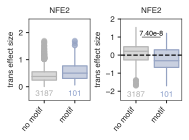

6.8597128822307916e-06


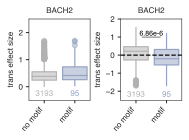

7.78979498613127e-10


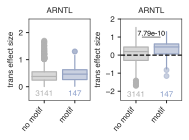

1.0172369476018756e-11


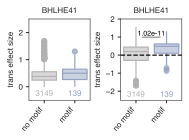

0.00010797452025130226


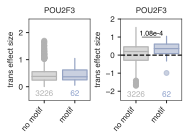

In [58]:
# example plots
# plot some examples
examps = ["NFE2", "BACH2", "ARNTL", "BHLHE41", "POU2F3"]
order = [False, True]
pal = {False: sns.color_palette("Set2")[7], True: sns.color_palette("Set2")[2]}

for symb in examps:
    motif_id = sig_results[sig_results["HGNC symbol"] == symb]["index"].iloc[0]
    
    tmp = data_filt_plot.copy()
    
    # determine whether motif is in human or mouse sequence
    human_motifs_sub = human_motifs[human_motifs["#pattern name"] == motif_id]["hg19_id"].unique()
    mouse_motifs_sub = mouse_motifs[mouse_motifs["#pattern name"] == motif_id]["mm9_id"].unique()
    tmp["hg19_motif"] = tmp["tss_id"].isin(human_motifs_sub)
    tmp["mm9_motif"] = tmp["tss_id"].isin(mouse_motifs_sub)
    tmp["has_motif"] = tmp[["hg19_motif", "mm9_motif"]].sum(axis=1).astype(bool)
    
    fig, axarr = plt.subplots(figsize=(2.75, 1.5), nrows=1, ncols=2)
    
    ax = axarr[0]
    sns.boxplot(data=tmp, x="has_motif", y="abs_logFC_trans", order=order, palette=pal, 
                flierprops = dict(marker='o', markersize=5), ax=ax)
    mimic_r_boxplot(ax)
    ax.set_xticklabels(["no motif", "motif"], rotation=50, 
                       ha="right", va="top")
    ax.set_ylabel("trans effect size")
    ax.set_title(symb)
    ax.set_xlabel("")
    
    for i, label in enumerate(order):
        n = len(tmp[tmp["has_motif"] == bool(label)])
        ax.annotate(str(n), xy=(i, -0.4), xycoords="data", xytext=(0, 0), 
                    textcoords="offset pixels", ha='center', va='bottom', 
                    color=pal[label], size=fontsize)

    ax.set_ylim((-0.5, 2.5))

    ax = axarr[1]
    sns.boxplot(data=tmp, x="has_motif", y="logFC_trans_one", order=order, palette=pal,
                flierprops = dict(marker='o', markersize=5), ax=ax)
    ax.set_xticklabels(["no motif", "motif"], rotation=50, ha="right", va="top")
    mimic_r_boxplot(ax)
    ax.set_ylabel("trans effect size")
    ax.set_title(symb)
    ax.set_xlabel("")
    ax.axhline(y=0, linestyle="dashed", color="black", zorder=100)
    
    for i, label in enumerate(order):
        n = len(tmp[tmp["has_motif"] == bool(label)])
        ax.annotate(str(n), xy=(i, -2.4), xycoords="data", xytext=(0, 0), 
                    textcoords="offset pixels", ha='center', va='bottom', 
                    color=pal[label], size=fontsize)
        
    ## annotate pvals
    sub1 = tmp[tmp["has_motif"] == True]
    sub2 = tmp[tmp["has_motif"] == False]
    vals1 = np.asarray(sub1["logFC_trans_one"])
    vals2 = np.asarray(sub2["logFC_trans_one"])
    vals1 = vals1[~np.isnan(vals1)]
    vals2 = vals2[~np.isnan(vals2)]
    u, pval = stats.mannwhitneyu(vals1, vals2, alternative="two-sided", use_continuity=False)
    print(pval)
    annotate_pval(ax, 0.2, 0.8, 1, 0, 1, pval, fontsize-1)
        
    ax.set_ylim((-2.5, 2))
        
    plt.subplots_adjust(wspace=0.5)
    if symb == "BACH2":
        fig.savefig("Fig5C_1.pdf", dpi="figure", bbox_inches="tight")
    elif symb == "POU2F3":
        fig.savefig("Fig5C_2.pdf", dpi="figure", bbox_inches="tight")
    plt.show()

In [59]:
pal = {"repressing": sns.color_palette("pastel")[3], "activating": sns.color_palette("pastel")[0]}

In [60]:
full_pal = {}
for i, row in sig_results.iterrows():
    full_pal[row["HGNC symbol"]] = pal[row["activ_or_repr"]]

In [61]:
sig_results_sub = sig_results.head(50)

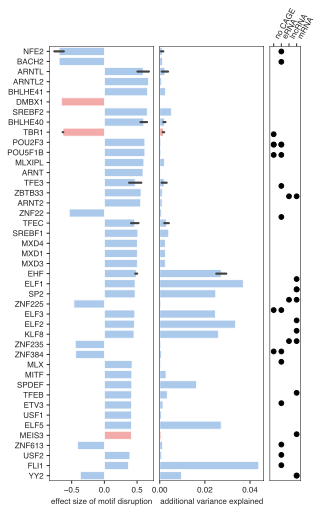

In [62]:
fig = plt.figure(figsize=(4.5, 8))

ax1 = plt.subplot2grid((1, 7), (0, 0), colspan=3)
ax2 = plt.subplot2grid((1, 7), (0, 3), colspan=3)
ax3 = plt.subplot2grid((1, 7), (0, 6), colspan=1)

yvals = []
symbs = []
c = 0
for i, row in sig_results_sub.iterrows():
    symb = row["HGNC symbol"]
    if symb not in symbs:
        yvals.append(c)
        symbs.append(symb)
        c += 1
    else:
        yvals.append(c)

sig_results_sub["yval"] = yvals
sns.barplot(y="HGNC symbol", x="beta_trans", data=sig_results_sub, palette=full_pal, ax=ax1)
ax1.set_ylabel("")
ax1.set_xlabel("effect size of motif disruption")

sns.barplot(y="HGNC symbol", x="rsq_activ", data=sig_results_sub, palette=full_pal, ax=ax2)
ax2.set_ylabel("")
ax2.tick_params(left=False, labelleft=False)
ax2.set_xlabel("additional variance explained")

melt = pd.melt(sig_results_sub, id_vars=["HGNC symbol", "yval"], value_vars=["no_CAGE_enr", "eRNA_enr",
                                                                                 "lncRNA_enr", "mRNA_enr"])
ax3.plot(melt["value"], melt["yval"], 'o', color="black")
ax3.set_xlim((-0.5, 3.5))
ax3.set_ylim((np.max(yvals)-0.5, -0.5))
ax3.tick_params(labelleft=False, labelbottom=False, bottom=False, left=False, top=True, labeltop=True)
ax3.xaxis.set_ticks([0, 1, 2, 3])
ax3.set_xticklabels(["no CAGE", "eRNA", "lncRNA", "mRNA"], rotation=60, ha="left", va="bottom")

plt.show()
# fig.savefig("trans_motif_enrichment.pdf", dpi="figure", bbox_inches="tight")
plt.close()

## 6. join with expression information

In [63]:
orth_expr.head()

,gene_id_human,gene_name_human,mean_tpm_human,gene_id_mouse,gene_name_mouse,mean_tpm_mouse,AveExpr,logFC,adj.P.Val,sig,neg_log_padj
0,ENSG00000142611,PRDM16,55.601719,ENSMUSG00000039410,Prdm16,612.953260,2.510447,4.964306,1.771139e-10,sig,9.751747
1,ENSG00000078900,TP73,117.897387,ENSMUSG00000029026,Trp73,239.674040,2.530112,2.552952,4.216300e-07,sig,6.375069
2,ENSG00000173673,HES3,272.208698,ENSMUSG00000028946,Hes3,0.000000,-1.119951,-7.611337,1.590728e-10,sig,9.798404
3,ENSG00000204859,ZBTB48,1251.437325,ENSMUSG00000028952,Zbtb48,342.804146,4.430457,-0.387987,5.686419e-02,not sig,1.245161
4,ENSG00000125945,ZNF436,136.434616,ENSMUSG00000051351,Zfp46,177.665949,2.222969,1.836888,4.656334e-06,sig,5.331956


In [64]:
trans_orth = motif_results_mrg.merge(orth_expr, left_on="HGNC symbol", right_on="gene_name_human")
len(trans_orth)

297

In [65]:
# fisher's exact to see if trans are enriched in DE TFs
trans_ids = trans_orth[trans_orth["padj_trans"] < 0.05]["index"].unique()
no_trans_ids = trans_orth[trans_orth["padj_trans"] >= 0.05]["index"].unique()
DE_ids = trans_orth[trans_orth["sig"] == "sig"]["index"].unique()

trans_w_DE = len([x for x in trans_ids if x in DE_ids])
trans_wo_DE = len([x for x in trans_ids if x not in DE_ids])
no_trans_w_DE = len([x for x in no_trans_ids if x in DE_ids])
no_trans_wo_DE = len([x for x in no_trans_ids if x not in DE_ids])

# fisher's exact test
arr = np.zeros((2, 2))
arr[0, 0] = trans_w_DE
arr[0, 1] = trans_wo_DE
arr[1, 0] = no_trans_w_DE
arr[1, 1] = no_trans_wo_DE

odds, p = stats.fisher_exact(arr)
print(odds)
print(p)

0.7860922146636432
0.3872904185705145


In [66]:
trans_orth_sig = trans_orth[trans_orth["padj_trans"] < 0.05]
trans_orth_sig["abs_beta"] = np.abs(trans_orth_sig["beta_trans"])
trans_orth_sig = trans_orth_sig.sort_values(by="abs_beta", ascending=False)
len(trans_orth_sig)

120

In [67]:
trans_orth_sub = trans_orth_sig[trans_orth_sig["sig"] == "sig"]
len(trans_orth_sub)

67

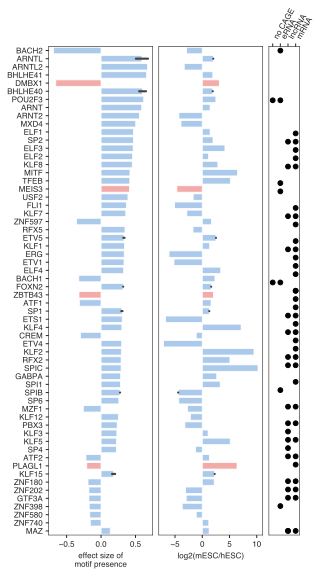

In [68]:
fig = plt.figure(figsize=(4.5, 9))

ax1 = plt.subplot2grid((1, 7), (0, 0), colspan=3)
ax2 = plt.subplot2grid((1, 7), (0, 3), colspan=3)
ax3 = plt.subplot2grid((1, 7), (0, 6), colspan=1)

yvals = []
symbs = []
c = 0
for i, row in trans_orth_sub.iterrows():
    symb = row["HGNC symbol"]
    if symb not in symbs:
        yvals.append(c)
        symbs.append(symb)
        c += 1
    else:
        yvals.append(c)

trans_orth_sub["yval"] = yvals
sns.barplot(y="HGNC symbol", x="beta_trans", data=trans_orth_sub, palette=full_pal, ax=ax1)
ax1.set_ylabel("")
ax1.set_xlabel("effect size of\nmotif presence")

sns.barplot(y="HGNC symbol", x="logFC", data=trans_orth_sub, palette=full_pal, ax=ax2)
ax2.set_ylabel("")
ax2.tick_params(left=False, labelleft=False)
ax2.set_xlabel("log2(mESC/hESC)")

melt = pd.melt(trans_orth_sub, id_vars=["HGNC symbol", "yval"], value_vars=["no_CAGE_enr", "eRNA_enr",
                                                                                 "lncRNA_enr", "mRNA_enr"])
ax3.plot(melt["value"], melt["yval"], 'o', color="black")
ax3.set_xlim((-0.5, 3.5))
ax3.set_ylim((np.max(yvals)-0.5, -0.5))
ax3.tick_params(labelleft=False, labelbottom=False, bottom=False, left=False, top=True, labeltop=True)
ax3.xaxis.set_ticks([0, 1, 2, 3])
ax3.set_xticklabels(["no CAGE", "eRNA", "lncRNA", "mRNA"], rotation=60, ha="left", va="bottom")

plt.show()
fig.savefig("FigS11.pdf", dpi="figure", bbox_inches="tight")
plt.close()

In [69]:
trans_orth.head()

,index,rsq_trans,beta_trans,beta_p,n_w_motif,padj_trans,lr_test,pval,rsq_activ,beta_activ,...,gene_name_human,mean_tpm_human,gene_id_mouse,gene_name_mouse,mean_tpm_mouse,AveExpr,logFC,adj.P.Val,sig,neg_log_padj
0,M00880_1,0.000117,-0.055164,5.893203e-01,133,6.892502e-01,11.810436,5.889964e-04,0.000722,-0.145814,...,TET1,3064.239983,ENSMUSG00000047146,Tet1,10056.383424,7.756684,3.290559,1.287374e-08,sig,7.890295
1,M05695_1,0.012027,0.333617,4.194719e-08,425,5.305086e-07,814.325975,4.143530e-179,0.048377,0.927295,...,ETV1,3538.729351,ENSMUSG00000004151,Etv1,33.769610,3.702712,-5.191616,1.828871e-09,sig,8.737817
2,M08469_1,0.009924,0.555989,6.439214e-07,106,6.753322e-06,17.121412,3.506475e-05,0.001047,0.200435,...,ARNT2,1192.114800,ENSMUSG00000015709,Arnt2,21.480244,2.390494,-4.280895,8.407105e-09,sig,8.075354
3,M09267_1,0.005856,0.390536,1.336630e-04,128,6.683148e-04,14.232193,1.615825e-04,0.000870,0.166539,...,USF2,4698.126860,ENSMUSG00000058239,Usf2,524.849466,5.658309,-1.674067,1.935368e-06,sig,5.713236
4,M10260_1,0.009851,0.284905,7.085194e-07,493,7.253889e-06,907.411028,2.403033e-199,0.053728,0.899031,...,GABPA,1287.968774,ENSMUSG00000008976,Gabpa,2641.502700,6.297760,2.660587,1.027774e-06,sig,5.988102


Text(0.05, 0.9, 'n = 297')

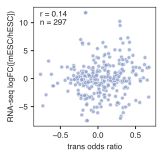

In [70]:
fig, ax = plt.subplots(figsize=(2.2, 2.2), nrows=1, ncols=1)

ax.scatter(trans_orth["beta_trans"], 
           trans_orth["logFC"],
           color=sns.color_palette("Set2")[2], alpha=0.75, s=15, 
           linewidths=0.5, edgecolors="white")

#ax.plot([-0.75, 400000], [-0.75, 400000], "k", linestyle="dashed")
#ax.set_xlim((-0.75, 400000))
#ax.set_ylim((-0.75, 400000))

ax.set_xlabel("trans odds ratio")
ax.set_ylabel("RNA-seq logFC([mESC/hESC])")

# annotate corr
no_nan = trans_orth[(~pd.isnull(trans_orth["beta_trans"])) & 
                    (~pd.isnull(trans_orth["logFC"]))]
r, p = spearmanr(no_nan["beta_trans"], no_nan["logFC"])
ax.text(0.05, 0.97, "r = {:.2f}".format(r), ha="left", va="top", fontsize=fontsize,
        transform=ax.transAxes)
ax.text(0.05, 0.90, "n = %s" % (len(no_nan)), ha="left", va="top", fontsize=fontsize,
        transform=ax.transAxes)

#fig.savefig("TF_human_v_mouse_scatter.w_sig_outline.pdf", dpi="figure", bbox_inches="tight")

In [71]:
# filter to those where direction matches
trans_orth_sub["direction_match"] = trans_orth_sub.apply(direction_match, axis=1)
trans_orth_sub.direction_match.value_counts()

match       44
no match    23
Name: direction_match, dtype: int64

In [72]:
trans_orth_match = trans_orth_sub[trans_orth_sub["direction_match"] == "match"]

In [73]:
match_activ = trans_orth_match[trans_orth_match["activ_or_repr"] == "activating"]
match_repr = trans_orth_match[trans_orth_match["activ_or_repr"] == "repressing"]

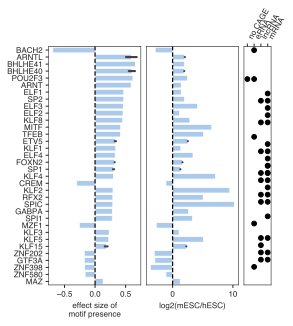

In [74]:
fig = plt.figure(figsize=(4, 4.4))

ax1 = plt.subplot2grid((1, 7), (0, 0), colspan=3)
ax2 = plt.subplot2grid((1, 7), (0, 3), colspan=3)
ax3 = plt.subplot2grid((1, 7), (0, 6), colspan=1)

yvals = []
symbs = []
c = 0
for i, row in match_activ.iterrows():
    symb = row["HGNC symbol"]
    if symb not in symbs:
        yvals.append(c)
        symbs.append(symb)
        c += 1
    else:
        yvals.append(c)

match_activ["yval"] = yvals
sns.barplot(y="HGNC symbol", x="beta_trans", data=match_activ, palette=full_pal, ax=ax1)
ax1.set_ylabel("")
ax1.set_xlabel("effect size of\nmotif presence")
ax1.axvline(x=0, linestyle="dashed", color="black")

sns.barplot(y="HGNC symbol", x="logFC", data=match_activ, palette=full_pal, ax=ax2)
ax2.set_ylabel("")
ax2.tick_params(left=False, labelleft=False)
ax2.set_xlabel("log2(mESC/hESC)")
ax2.axvline(x=0, linestyle="dashed", color="black")

melt = pd.melt(match_activ, id_vars=["HGNC symbol", "yval"], value_vars=["no_CAGE_enr", "eRNA_enr",
                                                                                 "lncRNA_enr", "mRNA_enr"])
ax3.plot(melt["value"], melt["yval"], 'o', color="black")
ax3.set_xlim((-0.5, 3.5))
ax3.set_ylim((np.max(yvals)-0.5, -0.5))
ax3.tick_params(labelleft=False, labelbottom=False, bottom=False, left=False, top=True, labeltop=True)
ax3.xaxis.set_ticks([0, 1, 2, 3])
ax3.set_xticklabels(["no CAGE", "eRNA", "lncRNA", "mRNA"], rotation=60, ha="left", va="bottom")

plt.show()
fig.savefig("Fig5B.pdf", dpi="figure", bbox_inches="tight")
plt.close()

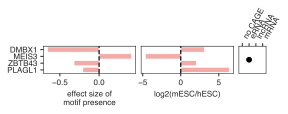

In [75]:
fig = plt.figure(figsize=(4, 0.5))

ax1 = plt.subplot2grid((1, 7), (0, 0), colspan=3)
ax2 = plt.subplot2grid((1, 7), (0, 3), colspan=3)
ax3 = plt.subplot2grid((1, 7), (0, 6), colspan=1)

yvals = []
symbs = []
c = 0
for i, row in match_repr.iterrows():
    symb = row["HGNC symbol"]
    if symb not in symbs:
        yvals.append(c)
        symbs.append(symb)
        c += 1
    else:
        yvals.append(c)

match_repr["yval"] = yvals
sns.barplot(y="HGNC symbol", x="beta_trans", data=match_repr, palette=full_pal, ax=ax1)
ax1.set_ylabel("")
ax1.set_xlabel("effect size of\nmotif presence")
ax1.axvline(x=0, linestyle="dashed", color="black")

sns.barplot(y="HGNC symbol", x="logFC", data=match_repr, palette=full_pal, ax=ax2)
ax2.set_ylabel("")
ax2.tick_params(left=False, labelleft=False)
ax2.set_xlabel("log2(mESC/hESC)")
ax2.axvline(x=0, linestyle="dashed", color="black")

melt = pd.melt(match_repr, id_vars=["HGNC symbol", "yval"], value_vars=["no_CAGE_enr", "eRNA_enr",
                                                                                 "lncRNA_enr", "mRNA_enr"])
ax3.plot(melt["value"], melt["yval"], 'o', color="black")
ax3.set_xlim((-0.5, 3.5))
ax3.set_ylim((np.max(yvals)-0.5, -0.5))
ax3.tick_params(labelleft=False, labelbottom=False, bottom=False, left=False, top=True, labeltop=True)
ax3.xaxis.set_ticks([0, 1, 2, 3])
ax3.set_xticklabels(["no CAGE", "eRNA", "lncRNA", "mRNA"], rotation=60, ha="left", va="bottom")

plt.show()
# fig.savefig("trans_motif_enrichment.with_expr.match_only.repr.pdf", dpi="figure", bbox_inches="tight")
plt.close()

## 7. join w/ % similarity information

In [76]:
orth.columns

Index(['Gene stable ID', 'Transcript stable ID', 'Gene name',
       'Mouse gene stable ID', 'Mouse protein or transcript stable ID',
       'Mouse gene name', '%id. target Mouse gene identical to query gene',
       '%id. query gene identical to target Mouse gene', 'dN with Mouse',
       'dS with Mouse', 'Mouse orthology confidence [0 low, 1 high]',
       'Mouse homology type'],
      dtype='object')

In [77]:
orth_sub = orth[["Gene name", "Mouse gene name", "dN with Mouse", "dS with Mouse"]]
orth_sub.columns = ["human_gene_name", "mouse_gene_name", "dN", "dS"]
orth_sub["dNdS"] = orth_sub["dN"]/orth_sub["dS"]

In [78]:
trans_orth = trans_orth.merge(orth_sub, left_on="HGNC symbol", right_on="human_gene_name").drop_duplicates()
print(len(trans_orth))
trans_orth.sample(5)

291


,index,rsq_trans,beta_trans,beta_p,n_w_motif,padj_trans,lr_test,pval,rsq_activ,beta_activ,...,AveExpr,logFC,adj.P.Val,sig,neg_log_padj,human_gene_name,mouse_gene_name,dN,dS,dNdS
1999,M08863_1,0.000709,-0.067313,0.184399,942,0.322323,35.326303,2.788407e-09,0.002158,0.118263,...,5.819428,1.441716,5.676930e-07,sig,6.245886,KLF10,Klf10,0.0864,0.5062,0.170684
2138,M06186_1,0.000005,-0.007121,0.911123,393,0.948626,13.499086,2.386797e-04,0.000825,-0.091279,...,-0.950929,5.361126,7.820189e-08,sig,7.106783,TFAP2A,Tfap2a,0.0061,0.2583,0.023616
1406,M09405_1,0.001714,-0.311467,0.039026,57,0.094809,9.377391,2.196780e-03,0.000573,-0.144548,...,3.347837,-0.160630,4.901767e-01,not sig,0.309647,ZNF821,Zfp821,0.0232,0.4108,0.056475
2617,ZNF180,0.004523,-0.189665,0.000792,1541,0.003373,37.224989,1.052563e-09,0.002274,0.126256,...,4.510640,2.190458,1.951412e-06,sig,5.709651,ZNF180,Zfp180,0.1971,1.0902,0.180793
0,M00880_1,0.000117,-0.055164,0.589320,133,0.689250,11.810436,5.889964e-04,0.000722,-0.145814,...,7.756684,3.290559,1.287374e-08,sig,7.890295,TET1,Tet1,0.3072,0.7374,0.416599


In [79]:
trans_orth["abs_l2fc"] = np.abs(trans_orth["logFC"])
trans_orth["sig_status"] = trans_orth.apply(sig_status, axis=1)
trans_orth.head()

,index,rsq_trans,beta_trans,beta_p,n_w_motif,padj_trans,lr_test,pval,rsq_activ,beta_activ,...,adj.P.Val,sig,neg_log_padj,human_gene_name,mouse_gene_name,dN,dS,dNdS,abs_l2fc,sig_status
0,M00880_1,0.000117,-0.055164,5.893203e-01,133,6.892502e-01,11.810436,5.889964e-04,0.000722,-0.145814,...,1.287374e-08,sig,7.890295,TET1,Tet1,0.3072,0.7374,0.416599,3.290559,not sig
1,M05695_1,0.012027,0.333617,4.194719e-08,425,5.305086e-07,814.325975,4.143530e-179,0.048377,0.927295,...,1.828871e-09,sig,8.737817,ETV1,Etv1,0.0095,0.2647,0.035890,5.191616,sig
24,M08469_1,0.009924,0.555989,6.439214e-07,106,6.753322e-06,17.121412,3.506475e-05,0.001047,0.200435,...,8.407105e-09,sig,8.075354,ARNT2,Arnt2,0.0103,0.5820,0.017698,4.280895,sig
33,M09267_1,0.005856,0.390536,1.336630e-04,128,6.683148e-04,14.232193,1.615825e-04,0.000870,0.166539,...,1.935368e-06,sig,5.713236,USF2,Usf2,0.0095,0.3464,0.027425,1.674067,sig
49,M10260_1,0.009851,0.284905,7.085194e-07,493,7.253889e-06,907.411028,2.403033e-199,0.053728,0.899031,...,1.027774e-06,sig,5.988102,GABPA,Gabpa,0.0189,0.4804,0.039342,2.660587,sig


In [80]:
trans_orth.sig_status.value_counts()

not sig    174
sig        117
Name: sig_status, dtype: int64

In [81]:
order = ["not sig", "sig"]
palette = {"not sig": "gray", "sig": sns.color_palette("Set2")[2]}

In [82]:
trans_orth_sig = trans_orth[trans_orth["sig_status"] == "sig"]
print(len(trans_orth_sig))
trans_orth_sig.head()

117


,index,rsq_trans,beta_trans,beta_p,n_w_motif,padj_trans,lr_test,pval,rsq_activ,beta_activ,...,adj.P.Val,sig,neg_log_padj,human_gene_name,mouse_gene_name,dN,dS,dNdS,abs_l2fc,sig_status
1,M05695_1,0.012027,0.333617,4.194719e-08,425,5.305086e-07,814.325975,4.143530e-179,0.048377,0.927295,...,1.828871e-09,sig,8.737817,ETV1,Etv1,0.0095,0.2647,0.035890,5.191616,sig
24,M08469_1,0.009924,0.555989,6.439214e-07,106,6.753322e-06,17.121412,3.506475e-05,0.001047,0.200435,...,8.407105e-09,sig,8.075354,ARNT2,Arnt2,0.0103,0.5820,0.017698,4.280895,sig
33,M09267_1,0.005856,0.390536,1.336630e-04,128,6.683148e-04,14.232193,1.615825e-04,0.000870,0.166539,...,1.935368e-06,sig,5.713236,USF2,Usf2,0.0095,0.3464,0.027425,1.674067,sig
49,M10260_1,0.009851,0.284905,7.085194e-07,493,7.253889e-06,907.411028,2.403033e-199,0.053728,0.899031,...,1.027774e-06,sig,5.988102,GABPA,Gabpa,0.0189,0.4804,0.039342,2.660587,sig
53,M05674_1,0.012004,0.336811,4.319677e-08,411,5.307032e-07,697.148532,1.246742e-153,0.041589,0.837709,...,3.513203e-07,sig,6.454297,ERG,Erg,0.0140,0.5232,0.026758,6.102636,sig


0.31230653975146105


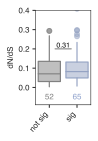

In [83]:
fig = plt.figure(figsize=(1, 1.75))
ax = sns.boxplot(data=trans_orth_sig, x="sig", y="dNdS", palette=palette, order=order,
                 flierprops = dict(marker='o', markersize=5))
mimic_r_boxplot(ax)

ax.set_xticklabels(order, rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_ylabel("dN/dS")

for i, label in enumerate(order):
    n = len(trans_orth_sig[trans_orth_sig["sig"] == label])
    ax.annotate(str(n), xy=(i, -0.07), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color=palette[label], size=fontsize)

ax.set_ylim((-0.09, 0.4))

# calc p-vals b/w dists
dist1 = np.asarray(trans_orth_sig[trans_orth_sig["sig"] == "sig"]["dNdS"])
dist2 = np.asarray(trans_orth_sig[trans_orth_sig["sig"] != "sig"]["dNdS"])

dist1 = dist1[~np.isnan(dist1)]
dist2 = dist2[~np.isnan(dist2)]

u, pval = stats.mannwhitneyu(dist1, dist2, alternative="two-sided", use_continuity=False)
print(pval)

annotate_pval(ax, 0.2, 0.8, 0.2, 0, 0.2, pval, fontsize-1)

plt.show()
# fig.savefig("DE_v_similarity_boxplot.pdf", dpi="figure", bbox_inches="tight")
plt.close()